In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from similarity_searching_sketches.stat_utils import interpret_corr_result
from similarity_searching_sketches.persistence import load_np_array
from similarity_searching_sketches.persistence import save_np_array
from similarity_searching_sketches.correlation_matrix import compute_corr_mtx
from similarity_searching_sketches.correlation_matrix import get_upper_triangle_values
from similarity_searching_sketches.correlation_matrix import get_one_vs_all_corrs
from similarity_searching_sketches.uncorrelated_bit_selection import select_random_subset
from similarity_searching_sketches.uncorrelated_bit_selection import fast_minimal_correlation_columns
from similarity_searching_sketches.uncorrelated_bit_selection import greedy_minimal_correlation_columns
from similarity_searching_sketches.log_utils import IterationLogger
from similarity_searching_sketches.visualization import hist_array
from similarity_searching_sketches.visualization import plot_array
from similarity_searching_sketches.visualization import scatter_array

In [29]:
DATA_FOLDER='/home/matej/data/sketch-testing/dataset_10K/'
SKETCH_MATRIX_PATH=DATA_FOLDER+'sketch_matrix.npy'
PIVOT_CAND_PATH=DATA_FOLDER+'pivot_candidates.npy' #array of pivot couple candidates sorted by balance score
BALANCE_SCORES_PATH=DATA_FOLDER+'balance_scores.npy' #array of balance scores of pivot candidate couples
HP_DISTANCES_PATH=DATA_FOLDER+'hp_distances.npy' #mean distances of objects to dividing hyperplane
TRAIN_SET_PATH=DATA_FOLDER+'train_set.npy' #read Training set from
SAVE_PIVOTS_TO=DATA_FOLDER+'selected_pivots.npy'
N_TOP_BALANCED = 500 #how many of most balanced pivot couple candidates to consider
DESIRED_SKETCH_LENGTH = 128
RANDOM_SUBSET_SELECTION_K=100 # N iterations for baseline bit subset selector
LOG_BY=16 #Log iterations by


#### Load data and select top K most balanced

In [3]:
sketch_matrix=load_np_array(SKETCH_MATRIX_PATH)[:,:N_TOP_BALANCED]
pivot_cand=load_np_array(PIVOT_CAND_PATH)[:N_TOP_BALANCED]
balance_scores=load_np_array(BALANCE_SCORES_PATH)[:N_TOP_BALANCED]
hp_distances=load_np_array(HP_DISTANCES_PATH)[:N_TOP_BALANCED]

In [4]:
sketch_matrix.shape

(8000, 500)

#### Compute Sketch Correlation Matrix 

In [5]:
corr_mtx=compute_corr_mtx(sketch_matrix)

#### Absolute pair-wise bit Pearson correlation

In [6]:
upper_triangle_values=get_upper_triangle_values(corr_mtx)

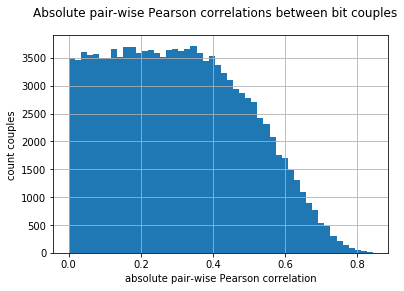

In [7]:
hist_array(arr=upper_triangle_values,bins=50,title='Absolute pair-wise Pearson correlations between bit couples',xlabel='absolute pair-wise Pearson correlation', ylabel='count couples')

Mean

In [8]:
np.mean(upper_triangle_values)

0.30357474513223981

Standard Deviaton 

In [9]:
np.std(upper_triangle_values)

0.18466929324372694

### 1 vs All correlations analysis

In [10]:
one_vs_all_corrs=np.array([np.mean(get_one_vs_all_corrs(corr_mtx, i)) for i in np.arange(corr_mtx.shape[1])])

#### Linear dependence of bit correlations on Balance scores

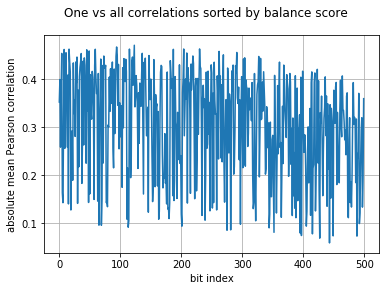

In [11]:
plot_array(arr=one_vs_all_corrs, title='One vs all correlations sorted by balance score', xlabel='bit index',ylabel='absolute mean Pearson correlation')

In [12]:
corr, pval=spearmanr(one_vs_all_corrs, balance_scores)

In [13]:
interpret_corr_result(corr,pval)

Computed correlation 0.244989722909 which can be interpreted as none or small positive linear dependence is statistically significant on confidence interval [0.95,1].


#### Linear dependence of bit correlations on Dividing hyperplane distances

In [14]:
sorted_args=np.argsort(hp_distances)[::-1]

In [15]:
hp_dist_sorted_corrs=one_vs_all_corrs[sorted_args]

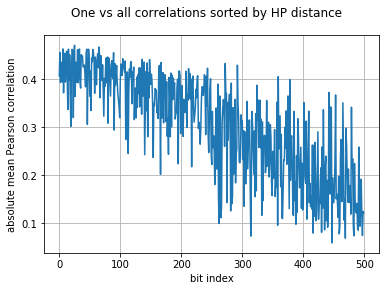

In [16]:
plot_array(arr=hp_dist_sorted_corrs, title='One vs all correlations sorted by HP distance', xlabel='bit index',ylabel='absolute mean Pearson correlation')

In [17]:
corr, pval=spearmanr(hp_dist_sorted_corrs, balance_scores)

In [18]:
interpret_corr_result(corr,pval)

Computed correlation 0.800060566704 which can be interpreted as moderate positive linear dependence is statistically significant on confidence interval [0.95,1].


### Bit subset selection

In [19]:
sketch_lengths=range(DESIRED_SKETCH_LENGTH+1)

In [20]:
baseline_results=[]
fmcc_results=[]
gmcc_results=[]
logger=IterationLogger(log_by=LOG_BY)

In [21]:
for sketch_len in sketch_lengths:
    logger.next_iter()
    baseline_results.append(select_random_subset(corr_mtx,sketch_len, RANDOM_SUBSET_SELECTION_K))
    fmcc_results.append(fast_minimal_correlation_columns(corr_mtx,sketch_len))
    gmcc_results.append(greedy_minimal_correlation_columns(corr_mtx,sketch_len))

INFO:IterationLogger| Started iteration no.: 16
 Time from previous iteration: 2.188922882080078s
 Time from start: 2.1889235973358154s
INFO:IterationLogger| Started iteration no.: 32
 Time from previous iteration: 9.223085880279541s
 Time from start: 11.412010669708252s
INFO:IterationLogger| Started iteration no.: 48
 Time from previous iteration: 17.77342391014099s
 Time from start: 29.18543577194214s
INFO:IterationLogger| Started iteration no.: 64
 Time from previous iteration: 29.808478116989136s
 Time from start: 58.99391484260559s
INFO:IterationLogger| Started iteration no.: 80
 Time from previous iteration: 45.26219463348389s
 Time from start: 104.25611066818237s
INFO:IterationLogger| Started iteration no.: 96
 Time from previous iteration: 62.15389895439148s
 Time from start: 166.41001105308533s
INFO:IterationLogger| Started iteration no.: 112
 Time from previous iteration: 83.54322528839111s
 Time from start: 249.95323729515076s
INFO:IterationLogger| Started iteration no.: 128


#### Results of bit selection

In [22]:
algorithms=['Baseline', 'FMCC', 'GMCC']
results=[baseline_results, fmcc_results, gmcc_results]


********************* Baseline algorithm ************************


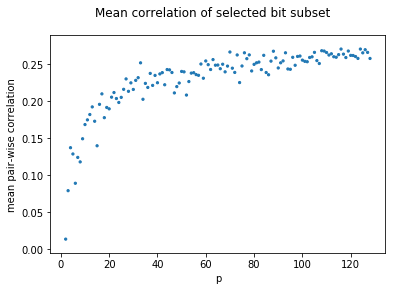

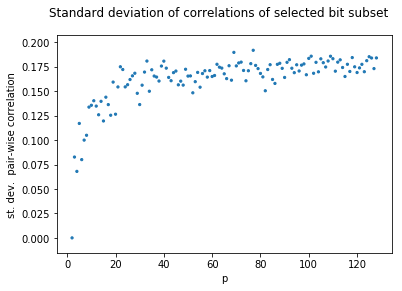

Resulting correlation for Sketch matrix with size 128 columns is 0.25782727008240264.

********************* FMCC algorithm ************************


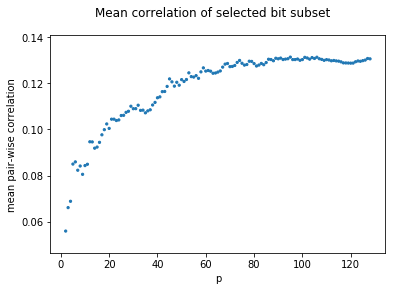

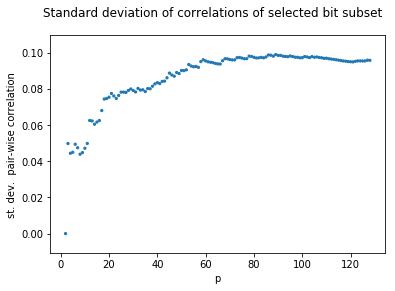

Resulting correlation for Sketch matrix with size 128 columns is 0.1305957860097974.

********************* GMCC algorithm ************************


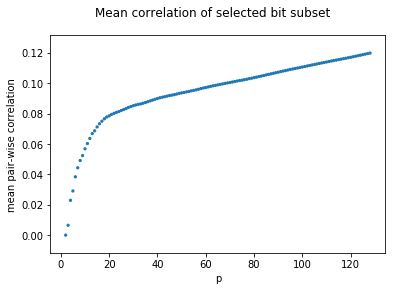

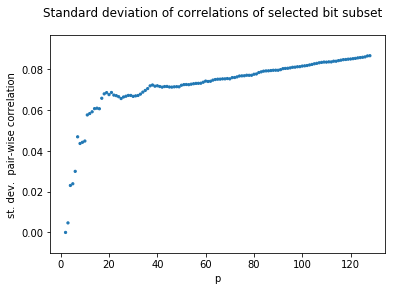

Resulting correlation for Sketch matrix with size 128 columns is 0.11983867851971305.


In [30]:
for i in range(len(algorithms)):
    name=algorithms[i]
    _, res_means, res_stds=zip(*results[i])
    print('\n********************* '+name+' algorithm ************************')
    scatter_array(res_means, point_size=5, title='Mean correlation of selected bit subset',xlabel='p', ylabel='mean pair-wise correlation')
    scatter_array(res_stds, point_size=5, title='Standard deviation of correlations of selected bit subset',xlabel='p', ylabel='st. dev.  pair-wise correlation')
    print('Resulting correlation for Sketch matrix with size {} columns is {}.'.format(DESIRED_SKETCH_LENGTH, res_means[DESIRED_SKETCH_LENGTH]))

#### Persist selected pivots

In [31]:
selected_indices=gmcc_results[DESIRED_SKETCH_LENGTH][0]

In [32]:
selected_pivots=pivot_cand[selected_indices]

In [33]:
selected_pivots.shape

(128, 2, 4096)

In [34]:
save_np_array(SAVE_PIVOTS_TO, selected_pivots)